#### Step 1: Import Required Libraries

In [40]:
import os
import numpy as np
import string
import pickle
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Add, Activation
import gc

# Paths
image_dir = '/content/drive/MyDrive/Images'
caption_file = '/content/captions.txt'
features_dir = 'features'
models_dir = 'models'
for d in [features_dir, models_dir]:
    os.makedirs(d, exist_ok=True)


#### Step 2: Load raw caption text into a Python dictionary


In [3]:
def load_captions(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    captions = dict()
    for line in lines:
        if ',' not in line: continue
        img, cap = line.strip().split(',', 1)
        captions.setdefault(img, []).append(cap)
    return captions

def clean_caption(caption):
    table = str.maketrans('', '', string.punctuation)
    words = caption.lower().split()
    words = [w.translate(table) for w in words]
    words = [w for w in words if w.isalpha() and len(w) > 1]
    return ' '.join(words)

def clean_all_captions(captions):
    for img, caps in captions.items():
        captions[img] = [clean_caption(c) for c in caps]
    return captions

def build_vocab(captions, min_freq=1):
    vocab = {}
    for caps in captions.values():
        for cap in caps:
            for word in cap.split():
                vocab[word] = vocab.get(word, 0) + 1
    return {w for w, c in vocab.items() if c >= min_freq}

# Load and clean captions
captions = load_captions(caption_file)
captions = clean_all_captions(captions)
vocab = build_vocab(captions)
print(f"Vocabulary size: {len(vocab)}")


Vocabulary size: 8762


####Step 3: Write cleaned caption data

In [4]:
def save_cleaned_captions(captions, filename):
    with open(filename, 'w') as f:
        for img, caps in captions.items():
            for cap in caps:
                f.write(f"{img}\t{cap}\n")
save_cleaned_captions(captions, 'cleaned_captions.txt')


####Step 4: Flatten all image captions into a single list

In [5]:
def all_captions_list(captions):
    return [c for caps in captions.values() for c in caps]

tokenizer = Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(all_captions_list(captions))
vocab_size = len(tokenizer.word_index) + 1
pickle.dump(tokenizer, open(os.path.join(models_dir, 'tokenizer.pkl'), 'wb'))

max_length = max(len(c.split()) for c in all_captions_list(captions))
print(f"Max caption length: {max_length}")


Max caption length: 32


#### Step 5: Build custom CNN for extracting image features

In [9]:
def build_custom_cnn():
    inputs = Input(shape=(224, 224, 3))

    # Initial layers with batch normalization
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # Block 1
    shortcut = x
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    # Block 2
    shortcut = Conv2D(128, 1, strides=1, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(128, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    # Block 3
    shortcut = Conv2D(256, 1, strides=2, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(256, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    # Block 4
    shortcut = Conv2D(512, 1, strides=2, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    # Final layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)

    return tf.keras.Model(inputs, x)


# Build and verify
cnn_model = build_custom_cnn()
cnn_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ activation_27[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_28[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 56, 56,    │          0 │ add_12[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │     73,856 │ activation_29[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │    147,584 │ activation_30[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │      8,320 │ activation_29[0]

 Total params: 56,297,216 (214.76 MB)

 Trainable params: 56,290,432 (214.73 MB)

 Non-trainable params: 6,784 (26.50 KB)

####Step 6: Traverse image folders and extract feature

In [10]:
def extract_features(directory, cnn_model):
    features = {}
    for img_name in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory, img_name)
        try:
            img = Image.open(img_path).resize((224,224)).convert('RGB')
            img = np.array(img).astype('float32') / 255.0
            img = np.expand_dims(img, axis=0)
            feat = cnn_model.predict(img, verbose=0)
            features[img_name] = feat[0]
        except Exception as e:
            print(f"Error with {img_name}: {e}")
    with open(os.path.join(features_dir, 'features.pkl'), 'wb') as f:
        pickle.dump(features, f)
    return features

features = extract_features(image_dir, cnn_model)
print(f"Extracted features for {len(features)} images")


100%|██████████| 8090/8090 [16:23<00:00,  8.23it/s]

Extracted features for 8090 images


####Step 7: Create input–output sequence pairs from captions

In [11]:
def create_sequences(tokenizer, max_length, desc_list, feature, vocab_size):
    X1, X2, y = [], [], []
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

def data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size=64):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for img, desc_list in descriptions.items():
            if img not in features: continue
            feature = features[img]
            xi, xii, yi = create_sequences(tokenizer, max_length, desc_list, feature, vocab_size)
            for i in range(len(xi)):
                X1.append(xi[i])
                X2.append(xii[i])
                y.append(yi[i])
                n += 1
                if n == batch_size:
                    # Fix for newer TensorFlow versions - return dictionary instead of list
                    yield {'input_1': np.array(X1), 'input_2': np.array(X2)}, np.array(y)
                    X1, X2, y = [], [], []
                    n = 0


####Step 8: Combine CNN features with LSTM layers to define the captioning model

In [25]:
def build_caption_model(vocab_size, max_length):
    # Image feature branch
    inputs1 = Input(shape=(512,), name='input_1')
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)

    # Caption branch
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 512, mask_zero=False)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(128, implementation=1)(se2)  # implementation=1 to avoid cuDNN issues

    # Decoder
    decoder1 = Add()((fe2, se3))
    decoder2 = Dense(128, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

caption_model = build_caption_model(vocab_size, max_length)
caption_model.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 32, 512)   │  4,487,168 │ input_2[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 512)       │          0 │ input_1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 32, 512)   │          0 │ embedding_9[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 128)       │     65,664 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 128)       │    328,192 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 128)       │          0 │ dense_29[0][0],   │
│                     │                   │            │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │     16,512 │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 8764)      │  1,130,556 │ dense_30[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,028,092 (23.00 MB)

 Trainable params: 6,028,092 (23.00 MB)

 Non-trainable params: 0 (0.00 B)

####Step 9: Split dataset into training and validation sets and train the model

Epoch 1/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0583 - loss: 6.6826

Memory cleaned after epoch

Epoch 1 Accuracy Metrics:
Training Accuracy: 0.0782
Validation Accuracy: 0.1128
568/568 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.0583 - loss: 6.6817 - val_accuracy: 0.1128 - val_loss: 5.7534
Epoch 2/20
565/568 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1231 - loss: 5.5822

Memory cleaned after epoch

Epoch 2 Accuracy Metrics:
Training Accuracy: 0.1315
Validation Accuracy: 0.1488
568/568 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1231 - loss: 5.5814 - val_accuracy: 0.1488 - val_loss: 5.3697
Epoch 3/20
567/568 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1579 - loss: 5.2214

Memory cleaned after epoch

Epoch 3 Accuracy Metrics:
Training Accuracy: 0.1646
Validation Accuracy: 0.1701
568/568 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.1579 - loss: 5.2212 - val_accuracy: 0.1701 - val_loss: 5.1437
Epoch 4/20
567/568 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1710 - loss: 5.0412

Memory cleaned after epoch

Epoch 4 Accuracy Metrics:
Training Accuracy: 0.1760
Validation Accuracy: 0.1935
568/568 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.1710 - loss: 5.0409 - val_accuracy: 0.1935 - val_loss: 4.7531
Epoch 5/20
567/568 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1877 - loss: 4.9249

Memory cleaned after epoch

Epoch 5 Accuracy Metrics:
Training Accuracy: 0.1911
Validation Accuracy: 0.2140
568/568 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1877 - loss: 4.9246 - val_accuracy: 0.2140 - val_loss: 4.5629
Epoch 6/20
567/568 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2033 - loss: 4.6938Memory cleaned after epoch

Epoch 6 Accuracy Metrics:
Training Accuracy: 0.2002
Validation Accuracy: 0.2021
568/568 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.2033 - loss: 4.6939 - val_accuracy: 0.2021 - val_loss: 4.7482
Epoch 7/20
567/568 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2123 - loss: 4.6260Memory cleaned after epoch

Epoch 7 Accuracy Metrics:
Training Accuracy: 0.2098
Validation Accuracy: 0.2153
568/568 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.2123 - loss: 4.6260 - val_accuracy: 0.2153 - val_loss: 4.6124
Epoch 8/20
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2147 - loss: 4.5900Memory cleaned after epoch

Epoch 8 Accuracy Metrics:
Trainin

Memory cleaned after epoch

Epoch 12 Accuracy Metrics:
Training Accuracy: 0.2256
Validation Accuracy: 0.2411
568/568 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.2217 - loss: 4.2730 - val_accuracy: 0.2411 - val_loss: 4.2670
Epoch 13/20
566/568 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2266 - loss: 4.2499

Memory cleaned after epoch

Epoch 13 Accuracy Metrics:
Training Accuracy: 0.2290
Validation Accuracy: 0.2530
568/568 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.2266 - loss: 4.2496 - val_accuracy: 0.2530 - val_loss: 4.1919
Epoch 14/20
567/568 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2335 - loss: 4.1355Memory cleaned after epoch

Epoch 14 Accuracy Metrics:
Training Accuracy: 0.2379
Validation Accuracy: 0.2329
568/568 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.2335 - loss: 4.1354 - val_accuracy: 0.2329 - val_loss: 4.4350
Epoch 15/20
566/568 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2352 - loss: 4.1598Memory cleaned after epoch

Epoch 15 Accuracy Metrics:
Training Accuracy: 0.2379
Validation Accuracy: 0.2433
568/568 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.2352 - loss: 4.1598 - val_accuracy: 0.2433 - val_loss: 4.2976
Epoch 16/20
566/568 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2486 - loss: 4.0617Memory cleaned after epoch

Epoch 16 Accuracy Metrics:



Model saved in both .h5 and .keras formats


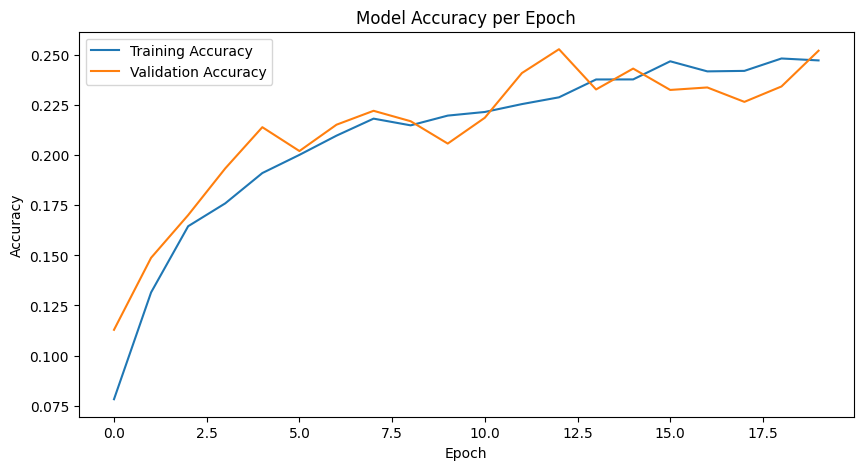

Training completed with accuracy tracking and models saved in multiple formats


In [56]:
# Split images for training/validation (e.g., 90/10 split)
all_imgs = list(captions.keys())
np.random.shuffle(all_imgs)
split = int(0.9 * len(all_imgs))
train_imgs = all_imgs[:split]
val_imgs = all_imgs[split:]

train_desc = {k: captions[k] for k in train_imgs}
val_desc = {k: captions[k] for k in val_imgs}
train_feats = {k: features[k] for k in train_imgs if k in features}
val_feats = {k: features[k] for k in val_imgs if k in features}

# Make sure your model is compiled with accuracy metric
caption_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

train_gen = data_generator(train_desc, train_feats, tokenizer, max_length, vocab_size, batch_size=64)
val_gen = data_generator(val_desc, val_feats, tokenizer, max_length, vocab_size, batch_size=64)

# Calculate steps
steps = sum(len(captions[k]) for k in train_imgs if k in features) // 64
val_steps = sum(len(captions[k]) for k in val_imgs if k in features) // 64

# Custom callback to display and log accuracy for each epoch
class AccuracyMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.train_accuracies = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)

        self.train_accuracies.append(train_acc)
        self.val_accuracies.append(val_acc)

        print(f"\nEpoch {epoch+1} Accuracy Metrics:")
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")

# Memory monitoring callback
class MemoryMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        print("Memory cleaned after epoch")

# Create a callback to save model in both formats
class SaveMultipleFormats(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        # Save in .h5 format (already done by ModelCheckpoint, but ensuring latest is saved)
        self.model.save(os.path.join(models_dir, 'caption_model.h5'))

        # Also save in .keras format (newer format with better compatibility)
        self.model.save(os.path.join(models_dir, 'caption_model.keras'))

        print("\nModel saved in both .h5 and .keras formats")

# Initialize the accuracy monitor
accuracy_monitor = AccuracyMonitor()

# Train the model with all callbacks
history = caption_model.fit(
    train_gen,
    steps_per_epoch=steps,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(models_dir, 'caption_model.h5'),
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(patience=15),
        MemoryMonitor(),
        accuracy_monitor,
        SaveMultipleFormats()
    ],
    verbose=1  # Show progress bar
)

# Optional: Plot accuracy over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(accuracy_monitor.train_accuracies, label='Training Accuracy')
plt.plot(accuracy_monitor.val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(models_dir, 'accuracy_plot.png'))
plt.show()

print("Training completed with accuracy tracking and models saved in multiple formats")


####Step 10: Train the model using k‑fold cross‑validation

In [19]:
def train_with_cross_validation(captions, features, tokenizer, max_length, vocab_size, k_folds=5, epochs=10, batch_size=64):
    """
    Train the model with k-fold cross-validation
    """
    # Get all image IDs
    all_imgs = list(captions.keys())
    np.random.shuffle(all_imgs)

    # Split into k folds
    fold_size = len(all_imgs) // k_folds
    folds = [all_imgs[i:i + fold_size] for i in range(0, len(all_imgs), fold_size)]

    # Ensure we have exactly k folds
    while len(folds) > k_folds:
        last_fold = folds.pop()
        folds[-1].extend(last_fold)

    # Store validation scores
    val_scores = []

    # Train k models
    for i in range(k_folds):
        print(f"\nTraining fold {i+1}/{k_folds}")

        # Get validation set
        val_imgs = folds[i]

        # Get training set (all other folds)
        train_imgs = []
        for j in range(k_folds):
            if j != i:
                train_imgs.extend(folds[j])

        # Create training and validation descriptions
        train_desc = {k: captions[k] for k in train_imgs if k in captions}
        val_desc = {k: captions[k] for k in val_imgs if k in captions}

        # Create features for training and validation sets
        train_feats = {k: features[k] for k in train_imgs if k in features}
        val_feats = {k: features[k] for k in val_imgs if k in features}

        # Create data generators
        train_gen = data_generator(train_desc, train_feats, tokenizer, max_length, vocab_size, batch_size)
        val_gen = data_generator(val_desc, val_feats, tokenizer, max_length, vocab_size, batch_size)

        # Calculate steps
        train_steps = sum(len(captions[k]) for k in train_imgs if k in features) // batch_size
        val_steps = sum(len(captions[k]) for k in val_imgs if k in features) // batch_size

        # Ensure at least one step
        train_steps = max(1, train_steps)
        val_steps = max(1, val_steps)

        # Build model
        model = build_caption_model(vocab_size, max_length)

        # Setup callbacks
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            os.path.join(models_dir, f'model_fold_{i+1}.h5'),
            monitor='val_loss',
            verbose=1,
            save_best_only=True
        )
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

        # Train the model
        history = model.fit(
            train_gen,
            steps_per_epoch=train_steps,
            epochs=epochs,
            validation_data=val_gen,
            validation_steps=val_steps,
            callbacks=[checkpoint, early_stopping, MemoryMonitor()],
            verbose=1
        )

        # Save validation score
        best_val_loss = min(history.history['val_loss'])
        val_scores.append(best_val_loss)

        # Plot training history
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training and Validation Loss - Fold {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(models_dir, f'loss_fold_{i+1}.png'))
        plt.close()

        # Clean up memory
        gc.collect()

    # Print cross-validation results
    print("\nCross-Validation Results:")
    for i, score in enumerate(val_scores):
        print(f"Fold {i+1}: Loss = {score:.4f}")
    print(f"Average Loss: {np.mean(val_scores):.4f}")

    return val_scores

  # Memory monitoring callback
class MemoryMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        print("Memory cleaned after epoch")


In [26]:
# perform cross-validation
print("\nPerforming cross-validation...")
val_scores = train_with_cross_validation(captions, features, tokenizer, max_length, vocab_size)



Performing cross-validation...

Training fold 1/5
Epoch 1/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.7092
Epoch 1: val_loss improved from inf to 5.71397, saving model to models/model_fold_1.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 6.7064 - val_loss: 5.7140
Epoch 2/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.5915
Epoch 2: val_loss improved from 5.71397 to 5.31760, saving model to models/model_fold_1.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.5909 - val_loss: 5.3176
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2613
Epoch 3: val_loss improved from 5.31760 to 5.08941, saving model to models/model_fold_1.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 5.2612 - val_loss: 5.0894
Epoch 4/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.0186
Epoch 4: val_loss improved from 5.08941 to 4.99243, saving model to models/model_fold_1.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.0186 - val_loss: 4.9924
Epoch 5/10
502/505 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9340
Epoch 5: val_loss improved from 4.99243 to 4.78132, saving model to models/model_fold_1.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.9339 - val_loss: 4.7813
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8380
Epoch 6: val_loss improved from 4.78132 to 4.63171, saving model to models/model_fold_1.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 4.8379 - val_loss: 4.6317
Epoch 7/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7868
Epoch 7: val_loss did not improve from 4.63171
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 4.7866 - val_loss: 4.6916
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.7540
Epoch 8: val_loss did not improve from 4.63171
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 4.7538 - val_loss: 4.6425
Epoch 9/10
502/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.6456
Epoch 9: val_loss did not improve from 4.63171
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.6447 - val_loss: 4.6399
Epoch 10/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.4418
Epoch 10: val_loss improved from 4.63171 to 4.56080, saving model to models/model_fold_1.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.4417 - val_loss: 4.5608

Training fold 2/5
Epoch 1/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.7174
Epoch 1: val_loss improved from inf to 5.83750, saving model to models/model_fold_2.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 6.7156 - val_loss: 5.8375
Epoch 2/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6368
Epoch 2: val_loss improved from 5.83750 to 5.40828, saving model to models/model_fold_2.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 5.6365 - val_loss: 5.4083
Epoch 3/10
502/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.2855
Epoch 3: val_loss improved from 5.40828 to 5.00531, saving model to models/model_fold_2.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.2853 - val_loss: 5.0053
Epoch 4/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.9964
Epoch 4: val_loss improved from 5.00531 to 5.00150, saving model to models/model_fold_2.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.9965 - val_loss: 5.0015
Epoch 5/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.9124
Epoch 5: val_loss improved from 5.00150 to 4.75496, saving model to models/model_fold_2.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 4.9124 - val_loss: 4.7550
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7995
Epoch 6: val_loss did not improve from 4.75496
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 4.7994 - val_loss: 4.7814
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.7729
Epoch 7: val_loss improved from 4.75496 to 4.62124, saving model to models/model_fold_2.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 4.7728 - val_loss: 4.6212
Epoch 8/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.7324
Epoch 8: val_loss did not improve from 4.62124
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.7322 - val_loss: 4.6565
Epoch 9/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.6245
Epoch 9: val_loss did not improve from 4.62124
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.6243 - val_loss: 4.6785
Epoch 10/10
502/505 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.4409
Epoch 10: val_loss did not improve from 4.62124
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 4.4405 - val_loss: 4.6717

Training fold 3/5
Epoch 1/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.7152
Epoch 1: val_loss improved from inf to 5.70649, saving model to models/model_fold_3.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 6.7133 - val_loss: 5.7065
Epoch 2/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.5381
Epoch 2: val_loss improved from 5.70649 to 5.31803, saving model to models/model_fold_3.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.5377 - val_loss: 5.3180
Epoch 3/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.2725
Epoch 3: val_loss improved from 5.31803 to 5.10344, saving model to models/model_fold_3.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.2722 - val_loss: 5.1034
Epoch 4/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0100
Epoch 4: val_loss improved from 5.10344 to 5.06325, saving model to models/model_fold_3.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 5.0098 - val_loss: 5.0632
Epoch 5/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9019
Epoch 5: val_loss improved from 5.06325 to 4.73783, saving model to models/model_fold_3.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.9019 - val_loss: 4.7378
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7782
Epoch 6: val_loss improved from 4.73783 to 4.71203, saving model to models/model_fold_3.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.7782 - val_loss: 4.7120
Epoch 7/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7707
Epoch 7: val_loss did not improve from 4.71203
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.7705 - val_loss: 4.7203
Epoch 8/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7401
Epoch 8: val_loss improved from 4.71203 to 4.69649, saving model to models/model_fold_3.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 4.7397 - val_loss: 4.6965
Epoch 9/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.5963
Epoch 9: val_loss improved from 4.69649 to 4.58663, saving model to models/model_fold_3.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.5961 - val_loss: 4.5866
Epoch 10/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4013
Epoch 10: val_loss did not improve from 4.58663
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.4012 - val_loss: 4.6507

Training fold 4/5
Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.7199
Epoch 1: val_loss improved from inf to 5.84134, saving model to models/model_fold_4.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 6.7190 - val_loss: 5.8413
Epoch 2/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6166
Epoch 2: val_loss improved from 5.84134 to 5.27586, saving model to models/model_fold_4.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.6162 - val_loss: 5.2759
Epoch 3/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.3116
Epoch 3: val_loss improved from 5.27586 to 5.14492, saving model to models/model_fold_4.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 5.3112 - val_loss: 5.1449
Epoch 4/10
502/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.0527
Epoch 4: val_loss improved from 5.14492 to 5.08217, saving model to models/model_fold_4.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.0524 - val_loss: 5.0822
Epoch 5/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.9563
Epoch 5: val_loss improved from 5.08217 to 4.78513, saving model to models/model_fold_4.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.9564 - val_loss: 4.7851
Epoch 6/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8160
Epoch 6: val_loss did not improve from 4.78513
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 4.8161 - val_loss: 4.8226
Epoch 7/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8288
Epoch 7: val_loss improved from 4.78513 to 4.58418, saving model to models/model_fold_4.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 4.8285 - val_loss: 4.5842
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7768
Epoch 8: val_loss did not improve from 4.58418
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.7767 - val_loss: 4.7163
Epoch 9/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.6561
Epoch 9: val_loss did not improve from 4.58418
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.6559 - val_loss: 4.7289
Epoch 10/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.4352
Epoch 10: val_loss improved from 4.58418 to 4.58079, saving model to models/model_fold_4.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 4.4350 - val_loss: 4.5808

Training fold 5/5
Epoch 1/10
502/505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.7281
Epoch 1: val_loss improved from inf to 5.91850, saving model to models/model_fold_5.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 6.7245 - val_loss: 5.9185
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.5851
Epoch 2: val_loss improved from 5.91850 to 5.34031, saving model to models/model_fold_5.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.5850 - val_loss: 5.3403
Epoch 3/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.2804
Epoch 3: val_loss improved from 5.34031 to 5.05170, saving model to models/model_fold_5.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.2799 - val_loss: 5.0517
Epoch 4/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.0223
Epoch 4: val_loss improved from 5.05170 to 4.95466, saving model to models/model_fold_5.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.0222 - val_loss: 4.9547
Epoch 5/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9180
Epoch 5: val_loss improved from 4.95466 to 4.89775, saving model to models/model_fold_5.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 4.9180 - val_loss: 4.8977
Epoch 6/10
502/505 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.7916
Epoch 6: val_loss improved from 4.89775 to 4.77131, saving model to models/model_fold_5.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.7916 - val_loss: 4.7713
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7717
Epoch 7: val_loss improved from 4.77131 to 4.64269, saving model to models/model_fold_5.h5


Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.7717 - val_loss: 4.6427
Epoch 8/10
503/505 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.7425
Epoch 8: val_loss did not improve from 4.64269
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.7421 - val_loss: 4.7819
Epoch 9/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5657
Epoch 9: val_loss did not improve from 4.64269
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 4.5655 - val_loss: 4.7627
Epoch 10/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4144
Epoch 10: val_loss did not improve from 4.64269
Memory cleaned after epoch
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 4.4143 - val_loss: 4.7032

Cross-Validation Results:
Fold 1: Loss = 4.5608
Fold 2: Loss = 4.6212
Fold 3: Loss = 4.5866
Fold 4: Loss = 4.5808
Fold 5: Loss = 4.6427
Average Loss: 4.5984


####Step 11: Set up grid search for tuning hyperparameters


In [34]:
def hyperparameter_tuning(captions, features, tokenizer, max_length, vocab_size):
    """
    Perform hyperparameter tuning to find the best model configuration
    """
    # Define hyperparameter grid
    embedding_dims = [128, 256, 512]
    lstm_units = [128, 256, 512]
    dropout_rates = [0.3, 0.4, 0.5]
    batch_sizes = [32, 64, 128]

    # Get a subset of data for tuning (to save time)
    all_imgs = list(captions.keys())
    np.random.shuffle(all_imgs)
    tuning_img_ids = all_imgs[:min(1000, len(all_imgs))]

    # Split into train and validation
    train_size = int(0.8 * len(tuning_img_ids))
    train_imgs = tuning_img_ids[:train_size]
    val_imgs = tuning_img_ids[train_size:]

    # Create training and validation descriptions
    train_desc = {k: captions[k] for k in train_imgs if k in captions}
    val_desc = {k: captions[k] for k in val_imgs if k in captions}

    # Create features for training and validation sets
    train_feats = {k: features[k] for k in train_imgs if k in features}
    val_feats = {k: features[k] for k in val_imgs if k in features}

    # Store results
    results = []

    # Try different combinations
    for embedding_dim in embedding_dims:
        for lstm_unit in lstm_units:
            for dropout_rate in dropout_rates:
                for batch_size in batch_sizes:
                    print(f"\nTrying: embedding_dim={embedding_dim}, lstm_units={lstm_unit}, dropout_rate={dropout_rate}, batch_size={batch_size}")

                    # Build model with current hyperparameters
                    inputs1 = Input(shape=(512,), name='input_1')
                    fe1 = Dropout(dropout_rate)(inputs1)
                    fe2 = Dense(lstm_unit, activation='relu')(fe1)

                    inputs2 = Input(shape=(max_length,), name='input_2')
                    se1 = Embedding(vocab_size, embedding_dim, mask_zero=False)(inputs2)
                    se2 = Dropout(dropout_rate)(se1)
                    se3 = LSTM(lstm_unit, implementation=1)(se2)

                    decoder1 = Add()((fe2, se3))
                    decoder2 = Dense(lstm_unit, activation='relu')(decoder1)
                    outputs = Dense(vocab_size, activation='softmax')(decoder2)

                    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
                    model.compile(loss='categorical_crossentropy', optimizer='adam')

                    # Create data generators
                    train_gen = data_generator(train_desc, train_feats, tokenizer, max_length, vocab_size, batch_size)
                    val_gen = data_generator(val_desc, val_feats, tokenizer, max_length, vocab_size, batch_size)

                    # Calculate steps
                    train_steps = sum(len(captions[k]) for k in train_imgs if k in features) // batch_size
                    val_steps = sum(len(captions[k]) for k in val_imgs if k in features) // batch_size

                    # Ensure at least one step
                    train_steps = max(1, train_steps)
                    val_steps = max(1, val_steps)

                    # Train for a few epochs
                    history = model.fit(
                        train_gen,
                        steps_per_epoch=train_steps,
                        epochs=5,  # Just a few epochs for tuning
                        validation_data=val_gen,
                        validation_steps=val_steps,
                        callbacks=[MemoryMonitor()],
                        verbose=1
                    )

                    # Get validation loss
                    val_loss = history.history['val_loss'][-1]

                    # Store result
                    results.append({
                        'embedding_dim': embedding_dim,
                        'lstm_units': lstm_unit,
                        'dropout_rate': dropout_rate,
                        'batch_size': batch_size,
                        'val_loss': val_loss
                    })

                    # Print current result
                    print(f"Validation Loss: {val_loss:.4f}")

                    # Clean up memory
                    del model
                    gc.collect()

    # Sort results by validation loss
    results.sort(key=lambda x: x['val_loss'])

    # Print best configurations
    print("\nBest Hyperparameter Configurations:")
    for i, result in enumerate(results[:5]):
        print(f"Rank {i+1}:")
        print(f"  Embedding Dim: {result['embedding_dim']}")
        print(f"  LSTM Units: {result['lstm_units']}")
        print(f"  Dropout Rate: {result['dropout_rate']}")
        print(f"  Batch Size: {result['batch_size']}")
        print(f"  Validation Loss: {result['val_loss']:.4f}")

    return results

In [35]:

# perform hyperparameter tuning
print("\nPerforming hyperparameter tuning...")
tuning_results = hyperparameter_tuning(captions, features, tokenizer, max_length, vocab_size)
best_params = tuning_results[0]
print(f"\nBest parameters found: {best_params}")


Performing hyperparameter tuning...

Trying: embedding_dim=128, lstm_units=128, dropout_rate=0.3, batch_size=32
Epoch 1/5
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.7659Memory cleaned after epoch
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 7.7539 - val_loss: 6.3947
Epoch 2/5
121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5037Memory cleaned after epoch
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.5002 - val_loss: 6.3599
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.1916Memory cleaned after epoch
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 6.1917 - val_loss: 5.9568
Epoch 4/5
121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.0316Memory cleaned after epoch
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.0327 - val_loss: 6.3844
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0410Memory cleaned after epoch
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.0415 - val_loss: 6.0021
Validation Loss: 6.0021

Trying: embedding

####Step 12: Train final model on full data using best parameters

In [43]:
def train_final_model(descriptions, features, tokenizer, max_length, vocab_size, best_params, epochs=30):
    """
    Train the final model with the best hyperparameters
    """
    # Extract best parameters
    embedding_dim = best_params['embedding_dim']
    lstm_units = best_params['lstm_units']
    dropout_rate = best_params['dropout_rate']
    batch_size = best_params['batch_size']

    # Build model with best hyperparameters
    inputs1 = Input(shape=(512,), name='input_1')
    fe1 = Dropout(dropout_rate)(inputs1)
    fe2 = Dense(lstm_units, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=False)(inputs2)
    se2 = Dropout(dropout_rate)(se1)
    se3 = LSTM(lstm_units)(se2)

    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(lstm_units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Filter to only include images that have features
    valid_img_ids = [img_id for img_id in captions.keys() if img_id in features]
    valid_descriptions = {img_id: captions[img_id] for img_id in valid_img_ids}

    print(f"Training final model with {len(valid_descriptions)} images")

    # Create data generator for all data
    data_gen = data_generator(valid_descriptions, features, tokenizer, max_length, vocab_size, batch_size)

    # Calculate steps
    steps = sum(len(captions_list) for captions_list in captions.values()) // batch_size
    steps = max(1, steps)

    # Setup callbacks
    checkpoint = ModelCheckpoint('models/best_model.h5', monitor='loss', verbose=1, save_best_only=True)

    # Train the model
    history = model.fit(
        data_gen,
        steps_per_epoch=steps,
        epochs=epochs,
        callbacks=[checkpoint],
        verbose=1
    )

    # Save the final model
    model.save('models/final_model.h5')

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss - Final Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('models/final_model_loss.png')
    plt.close()

    return model

# Train final model
final_model = train_final_model(captions, features, tokenizer, max_length, vocab_size, best_params)


Training final model with 8090 images
Epoch 1/30
1263/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.3254
Epoch 1: loss improved from inf to 5.88924, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 6.3247
Epoch 2/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1332
Epoch 2: loss improved from 5.88924 to 5.00866, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 5.1331
Epoch 3/30
1261/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8449
Epoch 3: loss improved from 5.00866 to 4.82375, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 4.8449
Epoch 4/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7493
Epoch 4: loss improved from 4.82375 to 4.81068, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 4.7494
Epoch 5/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8350
Epoch 5: loss improved from 4.81068 to 4.78917, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 4.8349
Epoch 6/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6250
Epoch 6: loss improved from 4.78917 to 4.60051, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 4.6250
Epoch 7/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6636
Epoch 7: loss did not improve from 4.60051
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 4.6636
Epoch 8/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.4529
Epoch 8: loss improved from 4.60051 to 4.41541, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 4.4529
Epoch 9/30
1262/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.3617
Epoch 9: loss improved from 4.41541 to 4.31868, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 4.3616
Epoch 10/30
1263/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.2143
Epoch 10: loss improved from 4.31868 to 4.12339, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 4.2141
Epoch 11/30
1263/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.9738
Epoch 11: loss improved from 4.12339 to 4.00844, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 3.9738
Epoch 12/30
1262/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.0102
Epoch 12: loss did not improve from 4.00844
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 4.0103
Epoch 13/30
1263/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.0917
Epoch 13: loss did not improve from 4.00844
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 4.0917
Epoch 14/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.0677
Epoch 14: loss did not improve from 4.00844
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 4.0676
Epoch 15/30
1262/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.0741
Epoch 15: loss did not improve from 4.00844
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 4.0741
Epoch 16/30
1262/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.0532
Epoch 16: loss improved from 4.00844 to 3.98575, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 4.0530
Epoch 17/30
1262/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.9923
Epoch 17: loss improved from 3.98575 to 3.93884, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 3.9922
Epoch 18/30
1263/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.8969
Epoch 18: loss improved from 3.93884 to 3.85970, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 3.8969
Epoch 19/30
1263/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6991
Epoch 19: loss improved from 3.85970 to 3.71363, saving model to models/best_model.h5


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 3.6992
Epoch 20/30
1260/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.8127
Epoch 20: loss did not improve from 3.71363
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 3.8126
Epoch 21/30
1261/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.8662
Epoch 21: loss did not improve from 3.71363
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 3.8661
Epoch 22/30
1263/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.8677
Epoch 22: loss did not improve from 3.71363
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 3.8676
Epoch 23/30
1262/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.8212
Epoch 23: loss did not improve from 3.71363
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 3.8212
Epoch 24/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7961
Epoch 24: loss did not improve from 3.71363
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 3.7961
Epoch 25/30
1262/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 3.5758
Epoch 28/30
1261/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.5959
Epoch 28: loss did not improve from 3.54909
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 3.5959
Epoch 29/30
1261/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6623
Epoch 29: loss did not improve from 3.54909
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 3.6624
Epoch 30/30
1261/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6575
Epoch 30: loss did not improve from 3.54909
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 3.6574


####Step 13: Generate captions for new images with the trained model

In [44]:
def generate_caption(image_path, model, tokenizer, max_length, cnn_model):
    """
    Generate a caption for a given image
    """
    # Get original filename
    filename = os.path.basename(image_path)

    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize

    # Extract features
    feature = cnn_model.predict(img_array, verbose=0)

    # Generate caption
    in_text = 'startseq'

    # Generate caption word by word
    for i in range(max_length):
        # Encode the current input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # Pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Predict next word
        yhat = model.predict([feature, sequence], verbose=0)

        # Get index with highest probability
        yhat = np.argmax(yhat)

        # Convert index to word
        word = ''
        for w, index in tokenizer.word_index.items():
            if index == yhat:
                word = w
                break

        # Stop if we predict the end of sequence
        if word == 'endseq':
            break

        # Append word to the caption
        in_text += ' ' + word

    # Remove start and end tokens
    caption = in_text.replace('startseq', '').replace('endseq', '').strip()

    return filename, caption

# Test the caption generator
def test_caption_generator(test_image_path, model, tokenizer, max_length, cnn_model):
    """
    Test the caption generator on a sample image
    """
    # Generate caption
    filename, caption = generate_caption(test_image_path, model, tokenizer, max_length, cnn_model)

    # Display image and caption
    img = Image.open(test_image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(f"Filename: {filename}\nCaption: {caption}")
    plt.axis('off')
    plt.show()

    return filename, caption


####Step 14: Convert integer tokens back into human‑readable words

In [57]:
def word_for_id(integer, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == integer:
            return word
    return None

def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict({'input_1': photo.reshape(1,-1), 'input_2': sequence}, verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text.replace('startseq', '').strip()


####Step 15: Load the model and evaluate by generating captions

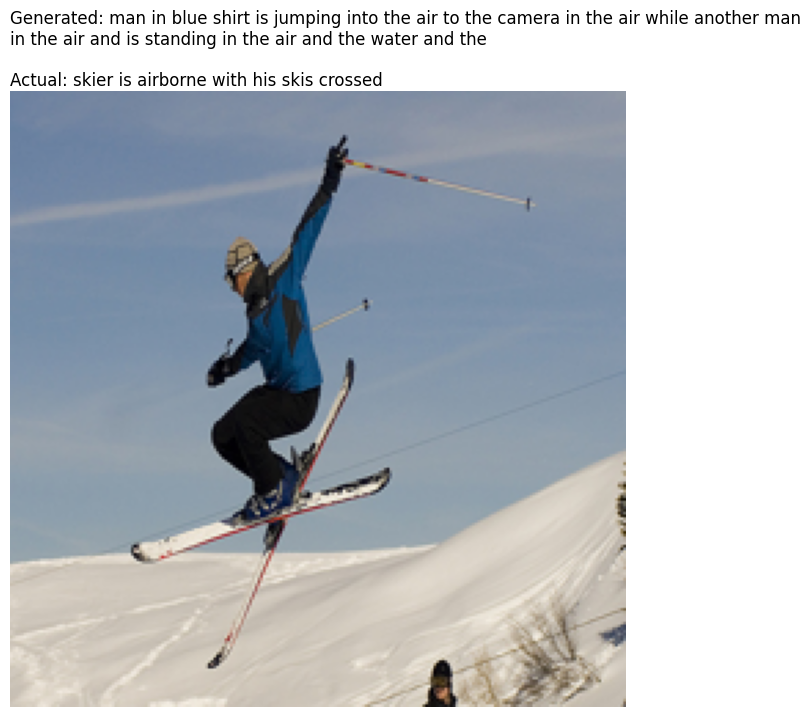

Image: 3329254388_27017bab30.jpg
Generated Caption: man in blue shirt is jumping into the air to the camera in the air while another man in the air and is standing in the air and the water and the
Actual Caption(s):
  1. skier is airborne with his skis crossed
  2. skier performs jumping trick on the slopes
  3. man flying through the air on skis over mountain
  4. the man is doing jump while skiing
  5. there is skier getting some air on the slopes

Output saved as: caption_test_result_3329254388_27017bab30.png


In [60]:
# Define paths
image_dir = '/content/drive/MyDrive/Images'
models_dir = 'models'

# Load the tokenizer
with open(os.path.join(models_dir, 'tokenizer.pkl'), 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the CNN model
# cnn_model = load_model(os.path.join(models_dir, 'cnn_model.h5'))

# First try to load the final model
caption_model = load_model(os.path.join(models_dir, 'final_model.h5'))

# Load the caption model
caption_model = load_model(os.path.join(models_dir, 'caption_model.h5'))

# Load captions dictionary (if available)
try:
    with open('cleaned_captions.txt', 'r') as f:
        lines = f.readlines()

    captions = {}
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            img, cap = parts
            if img not in captions:
                captions[img] = []
            captions[img].append(cap)
except:
    # If cleaned_captions.txt is not available, try loading from the original file
    with open('/content/captions.txt', 'r') as f:
        lines = f.readlines()

    captions = {}
    for line in lines:
        if ',' not in line: continue
        img, cap = line.strip().split(',', 1)
        if img not in captions:
            captions[img] = []
        captions[img].append(cap)

# Get all image files from the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Select a random image
random_img = random.choice(image_files)
img_path = os.path.join(image_dir, random_img)

# Function to generate caption
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Handle different model input formats
        try:
            yhat = model.predict({'input_1': photo.reshape(1,-1), 'input_2': sequence}, verbose=0)
        except:
            yhat = model.predict([photo.reshape(1,-1), sequence], verbose=0)

        yhat = np.argmax(yhat)

        # Convert index to word
        word = None
        for w, idx in tokenizer.word_index.items():
            if idx == yhat:
                word = w
                break

        # Stop if we predict the end of sequence or can't find the word
        if word is None or word == 'endseq':
            break

        in_text += ' ' + word

    return in_text.replace('startseq', '').strip()

# Load and preprocess the image
img = Image.open(img_path).resize((224, 224)).convert('RGB')
img_array = np.array(img).astype('float32') / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Extract features
features = cnn_model.predict(img_array, verbose=0)

# Get the maximum caption length
max_length = 32

# Generate caption
generated_caption = generate_caption(caption_model, tokenizer, features[0], max_length)

# Get actual captions if available
img_name = os.path.basename(img_path)
actual_captions = captions.get(img_name, ["No actual caption available"])

# Create a figure with the image and captions
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')

# Create title with generated and actual captions
title = f"Generated: {generated_caption}\n\nActual: {actual_captions[0]}"
plt.title(title, fontsize=12, loc='left', wrap=True)

# Add a border for better visibility
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

# Save the visualization
output_filename = f"caption_test_result_{os.path.splitext(img_name)[0]}.png"
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
plt.show()

# Print information
print(f"Image: {img_name}")
print(f"Generated Caption: {generated_caption}")
print(f"Actual Caption(s):")
for i, cap in enumerate(actual_captions):
    print(f"  {i+1}. {cap}")
print(f"\nOutput saved as: {output_filename}")
